In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings

warnings.filterwarnings('ignore')

In [5]:
df_true = pd.read_csv('True.csv')
df_fake = pd.read_csv('Fake.csv')

In [31]:
df_true['label'] = 1
df_fake['label'] = 0

# Combine True and Fake files

In [32]:
df = pd.concat([df_true , df_fake] , axis=0)

In [33]:
df = df.sample(frac=1 , random_state=42).reset_index(drop = True)

In [34]:
df['content'] = df['title'] + " " + df['text']

In [35]:
df = df[['content' , 'label']]

In [36]:
df.head()

,content,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,0
1,Failed GOP Candidates Remembered In Hilarious...,0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,0
3,California AG pledges to defend birth control ...,1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,0


# Preprocessing

In [37]:
df.isnull().sum()

content    0
label      0
dtype: int64

In [38]:
df['content'].duplicated().sum()

np.int64(5793)

In [40]:
df = df.drop_duplicates(subset="content")
df = df.reset_index(drop=True)

# Clean text

In [46]:
df['content'] = df['content'].apply(
    lambda x : x.lower()
)

In [47]:
import re
def preprocess(txt):
        txt = re.sub(r"<.*?>", " ", txt)
        return txt
df['content'] = df['content'].apply(preprocess)

In [48]:
import string
def remove_punc(txt):
    txt = txt.translate(str.maketrans('','',string.punctuation))
    return txt

df['content'] = df['content'].apply(remove_punc)

In [49]:
def remove_didgit(txt):
    new = ''
    for i in txt:
        if not i.isdigit():
            new = new + i
    return new
df['content'] = df['content'].apply(remove_didgit)

In [50]:
def remove_emojis(txt):
    new = ''
    for i in txt:
        if i.isascii():
            new = new + i
    return new
df['content'] = df['content'].apply(remove_emojis)

# Remove Stopwords

In [56]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [57]:
stop_words = set(stopwords.words('english'))
def remove_stopwrods(txt):
    cleaned = []
    words = word_tokenize(txt)
    for i in words:
        if not i in stop_words:
            cleaned.append(i)
    return ' '.join(cleaned)
df['content'] = df['content'].apply(remove_stopwrods)

# Lemmatization

In [58]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
def lem_text(txt):
    words = word_tokenize(txt)
    lematize = []
    for i in words:
        lematize.append(lem.lemmatize(i))
    return ' '.join(lematize)

df['content'] = df['content'].apply(lem_text)

# Vectorizarion

In [59]:
X = df['content']
y = df['label']

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , f1_score , confusion_matrix

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [63]:
tfidf = TfidfVectorizer()
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

# Building Model 

In [64]:
model = LogisticRegression()
model.fit(X_train_tf , y_train)

LogisticRegression()

In [68]:
y_pred_LR = model.predict(X_test_tf)
print(accuracy_score(y_pred_LR , y_test))
print(f1_score(y_pred_LR , y_test))

0.9838895281933256
0.9851764705882353


In [67]:
confusion_matrix(y_pred_LR , y_test)

array([[3508,   43],
       [  83, 4187]])

In [69]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_tf , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [70]:
y_pred_xgb = model_xgb.predict(X_test_tf)
print(accuracy_score(y_pred_xgb , y_test))
print(f1_score(y_pred_xgb , y_test))

0.9961641733793632
0.9964605946201038


In [71]:
confusion_matrix(y_pred_xgb , y_test)

array([[3568,    7],
       [  23, 4223]])

# Word Cloud

In [72]:
from wordcloud import WordCloud 
real_text = " ".join(df[df["label"] == 1]["content"])
fake_text = " ".join(df[df["label"] == 0]["content"])

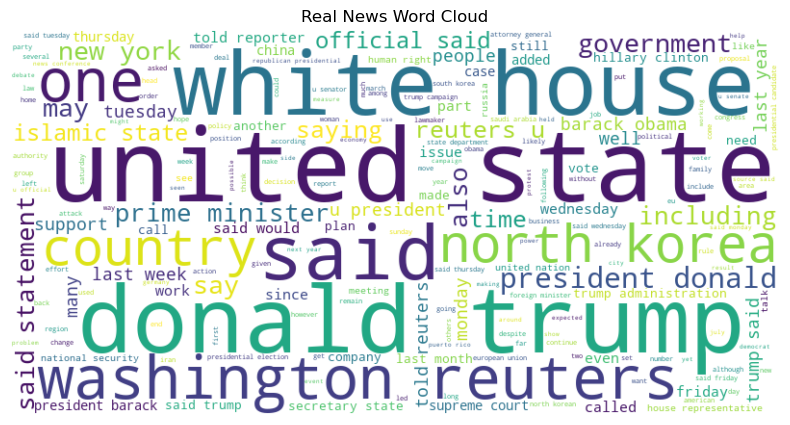

In [73]:
wordcloud_real = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords='english'
).generate(real_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("Real News Word Cloud")
plt.show()

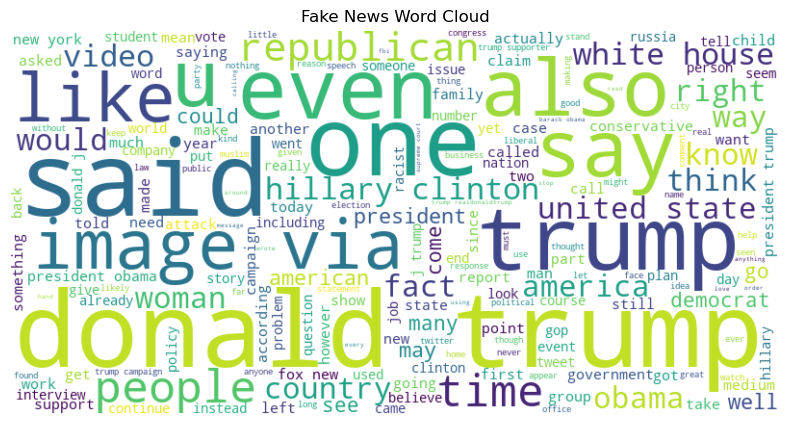

In [74]:
wordcloud_fake = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords='english'
).generate(fake_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Fake News Word Cloud")
plt.show()